## Comparison of different over-sampling techniques for highly imbalanced data

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import RandomOverSampler

### Getting data
To compare how different techniques over-sample data, we will use a highly imbalanced dataset for fraud analysis.
This dataset contains the result of PCA to reduce the number of features and hide sensitive information for privacy reasons.

In [2]:
data = pd.read_csv("fraud_data.csv")
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.176563,0.323798,0.536927,1.047002,-0.368652,-0.728586,0.084678,-0.069246,-0.266389,0.155315,...,-0.109627,-0.341365,0.057845,0.499180,0.415211,-0.581949,0.015472,0.018065,4.67,0
1,0.681109,-3.934776,-3.801827,-1.147468,-0.735540,-0.501097,1.038865,-0.626979,-2.274423,1.527782,...,0.652202,0.272684,-0.982151,0.165900,0.360251,0.195321,-0.256273,0.056501,912.00,0
2,1.140729,0.453484,0.247010,2.383132,0.343287,0.432804,0.093380,0.173310,-0.808999,0.775436,...,-0.003802,0.058556,-0.121177,-0.304215,0.645893,0.122600,-0.012115,-0.005945,1.00,0
3,-1.107073,-3.298902,-0.184092,-1.795744,2.137564,-1.684992,-2.015606,-0.007181,-0.165760,0.869659,...,0.130648,0.329445,0.927656,-0.049560,-1.892866,-0.575431,0.266573,0.414184,62.10,0
4,-0.314818,0.866839,-0.124577,-0.627638,2.651762,3.428128,0.194637,0.670674,-0.442658,0.133499,...,-0.312774,-0.799494,-0.064488,0.953062,-0.429550,0.158225,0.076943,-0.015051,2.67,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21693 entries, 0 to 21692
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      21693 non-null  float64
 1   V2      21693 non-null  float64
 2   V3      21693 non-null  float64
 3   V4      21693 non-null  float64
 4   V5      21693 non-null  float64
 5   V6      21693 non-null  float64
 6   V7      21693 non-null  float64
 7   V8      21693 non-null  float64
 8   V9      21693 non-null  float64
 9   V10     21693 non-null  float64
 10  V11     21693 non-null  float64
 11  V12     21693 non-null  float64
 12  V13     21693 non-null  float64
 13  V14     21693 non-null  float64
 14  V15     21693 non-null  float64
 15  V16     21693 non-null  float64
 16  V17     21693 non-null  float64
 17  V18     21693 non-null  float64
 18  V19     21693 non-null  float64
 19  V20     21693 non-null  float64
 20  V21     21693 non-null  float64
 21  V22     21693 non-null  float64
 22

### Viasualizing "Class" distribution

The dataset is already cleaned. We're interested in the column called "Class". This is the variable that tells which 
transactions resulted in a fraud (Class: 1) and which ones did not (Class: 0). Let's see its distribution.

In [4]:
pd.DataFrame({"Count": data["Class"].value_counts(), "Percentage": data["Class"].value_counts(normalize=True)})

,Count,Percentage
0,21337,0.983589
1,356,0.016411


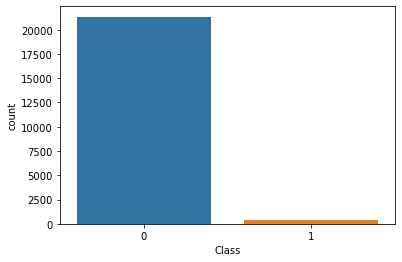

In [5]:
sns.countplot(x="Class", data=data);

The distribution of "Class" is highly imbalanced as expected. 

### Visualizing "Class" clusters.

Let's visualize the two classes by building pairwise scatterplots. As there are 28 predictors, there will be 378 pairs to use, which is a lot. We will display 10 different scatterplots to see if the two clusters are clearly distinguishable.

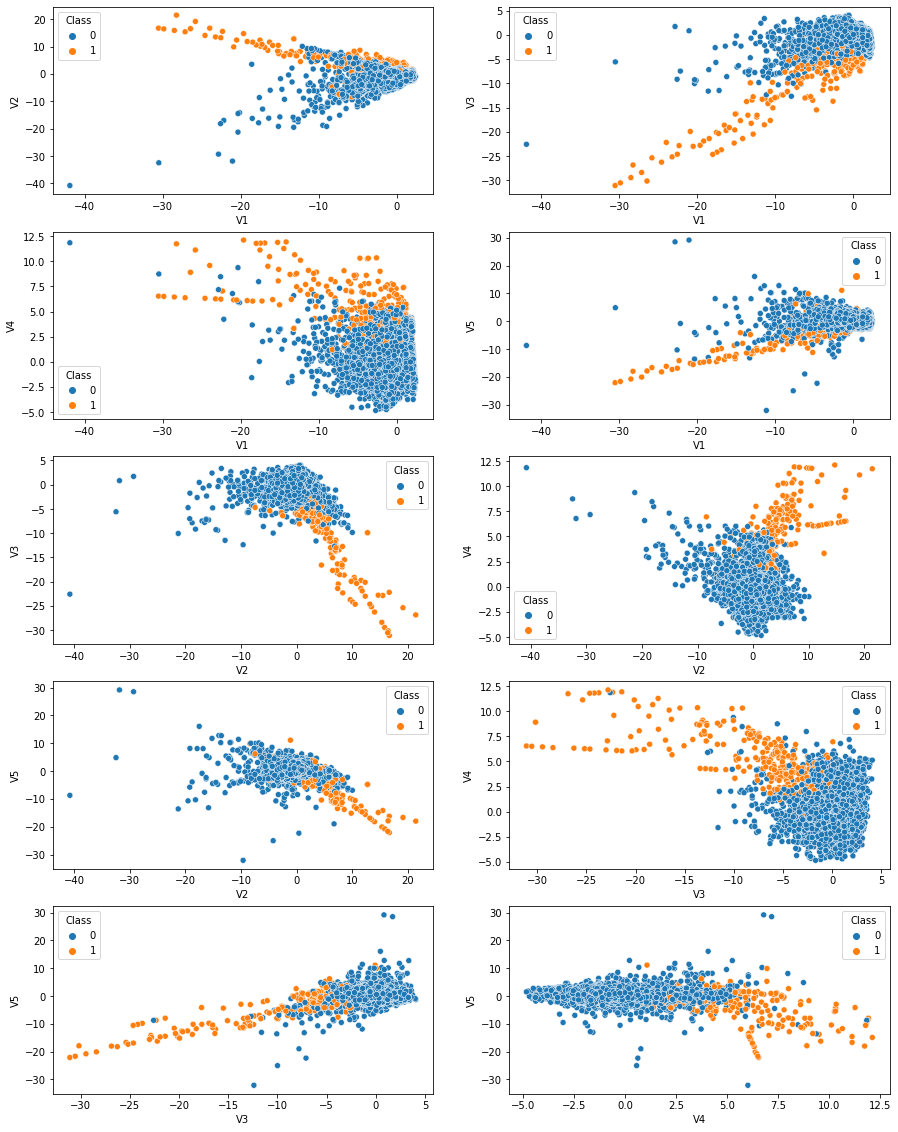

In [6]:
pairs = list(combinations(data.columns[:5], 2))

fig, axes = plt.subplots(round(len(pairs) / 2), 2, figsize=(15, 20))
for idx, (x_col, y_col) in enumerate(pairs):
    i, j = divmod(idx, 2)
    sns.scatterplot(x=x_col, y=y_col, hue="Class", data=data, ax=axes[i, j])

### Prepering data for model building and validation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:29]], data["Class"], train_size=0.8, stratify=data["Class"])

### Using different over-sampling techniques for comparison

In this experiment we will use regular **SMOTE**, **Borderline SMOTE**, **SVM SMOTE** and **Random Over-Sampler**, and see how these techniques affect our predictive model. 

Unlike the regular SMOTE which uses all data points of the minority class to generate synthetic examples, Borderline SMOTE does that using data points that are in "danger", i.e. more likely to be misclassified. As a result, more examples will be created along the borderline, where data points of the two classes overlap. It uses KNN to determine the "danger" data points.

SVM SMOTE is similar to Borderline SMOTE, except that it uses SVM to determine the data points in "danger".

In [51]:
smote = SMOTE(sampling_strategy=0.5)
bsmote = BorderlineSMOTE(sampling_strategy=0.5)
svmsmote = SVMSMOTE(sampling_strategy=0.5)
ros = RandomOverSampler(sampling_strategy=0.5)

In [9]:
comparison_items = [{
    "name": "Original",
    "model": None,
    "X": X_train,
    "y": y_train
},{
    "name": "SMOTE",
    "model": smote,
    "X": None,
    "y": None
}, {
    "name": "Borderline SMOTE",
    "model": bsmote,
    "X": None,
    "y": None
}, {
    "name": "SVM SMOTE",
    "model": svmsmote,
    "X": None,
    "y": None
}, {
    "name": "Random Over-Sampler",
    "model": ros,
    "X": None,
    "y": None
}]
for item in comparison_items:
    if item["model"]:
        item["X"], item["y"] = item["model"].fit_resample(X_train, y_train)

### Visualizing over-sampled data

In [10]:
def draw_comparisons(pair):
    fig, axes = plt.subplots(5, 1, figsize=(15, 30))
    for idx, item in enumerate(comparison_items):
        data = item["X"].copy()
        data["Class"] = item["y"]
        sns.scatterplot(x=pair[0], y=pair[1], hue="Class", data=data, ax=axes[idx], alpha=0.1)
        axes[idx].set_title("{0} ({1} vs {2})".format(item["name"], pair[0], pair[1]))

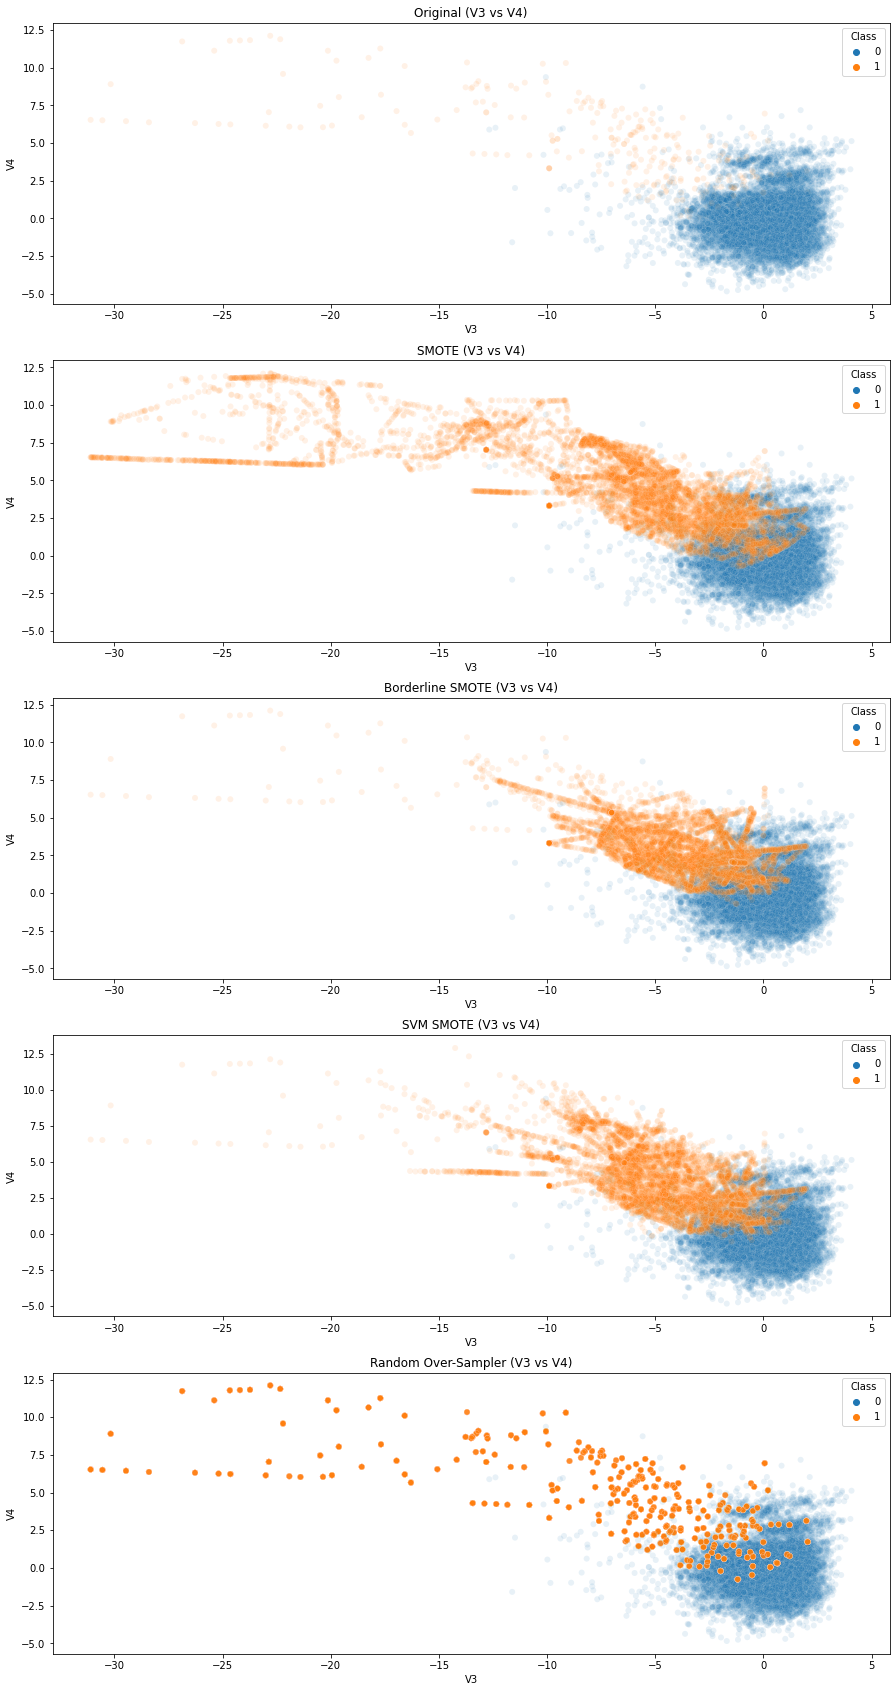

In [52]:
# We can try using different pairs of predictors

# draw_comparisons(("V1", "V3"))
# draw_comparisons(("V1", "V4"))
draw_comparisons(("V3", "V4"))

### Checking model performance

In this experiment we're using Random Forest Classifier. Let's see how different over-sampling techniques affect the predictive model using stratified K-Fold cross-validation.

In [55]:
cv = StratifiedKFold(n_splits=10)

for item in comparison_items:
    rfc = RandomForestClassifier()
    scores = cross_val_score(rfc, item["X"], item["y"], scoring="roc_auc", cv=cv)
    item["roc_auc_score"] = scores.mean()

In [59]:
print("Cross-validation ROC AUC scores:\n")
for item in comparison_items:
    print(item["name"], ": ", item["roc_auc_score"])

Cross-validation ROC AUC scores:

Original :  0.965033097850446
SMOTE :  0.9999200319430726
Borderline SMOTE :  0.9996971967608568
SVM SMOTE :  0.9996631005011679
Random Over-Sampler :  1.0


Looking at the cross-validation result, we see that all over-sampling techniques improve the performance of our classifier compared to the non-oversampled data. 

Let's see how the model will perform on the test data. For highly imbalanced data it's more useful to check F1 scores as opposed to ROC AUC, so in addition to ROC, we will also plot Precision-Recall curves.

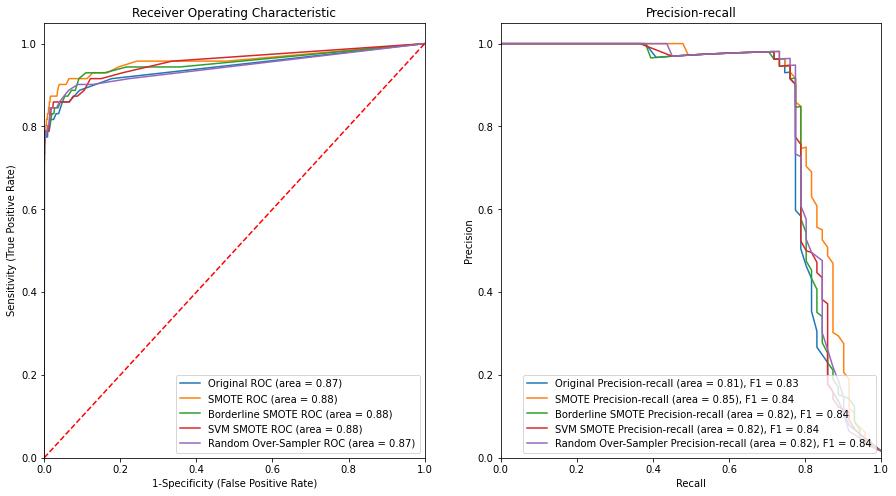

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

for item in comparison_items:
    rfc = RandomForestClassifier(n_estimators=200)
    rfc.fit(item["X"], item["y"])
    y_pred=rfc.predict(X_test)
    item["y_pred"] = y_pred

    # ROC
    fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
    auc_score = roc_auc_score(y_test,rfc.predict(X_test))
    ax1.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (item['name'], auc_score))
    
    # Precision-recall
    precision, recall, thresholds = precision_recall_curve(y_test, rfc.predict_proba(X_test)[:,1])
    auc_score = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    ax2.plot(recall, precision, label='%s Precision-recall (area = %0.2f), F1 = %0.2f' % (item['name'], auc_score, f1))
    
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('1-Specificity (False Positive Rate)')
ax1.set_ylabel('Sensitivity (True Positive Rate)')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-recall')
ax2.legend(loc="lower right");

In conclusion, we can clearly see the effects of different over-sampling techniques on classifying highly imbalanced data. We see improved performance using all of the SMOTE techniques in the experiment, while using Random Over-Sampler is almost as good as not using any oversampling at all in terms of accuracy.